In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

#### Data

In [17]:
# Load dataset with only the ToTensor transform to compute mean and std
compute_transform = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.FashionMNIST(root='data', 
                                            train=True, 
                                            transform=compute_transform, 
                                            download=True)
loader = torch.utils.data.DataLoader(dataset, 
                                     batch_size=1024, 
                                     shuffle=False, 
                                     num_workers=10)

mean = 0.0
for images, _ in loader:
    batch_samples = images.size(0)  # Batch size
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

variance = 0.0
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    variance += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(variance / (len(loader.dataset)*28*28))

print(mean, std)

tensor([0.2860]) tensor([0.3530])


In [18]:
# Load CFashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((mean,), (std,))])

trainset = torchvision.datasets.FashionMNIST(root='data', 
                                             train=True, 
                                             download=True, 
                                             transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=1024, 
                                          num_workers=10, 
                                          shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='data', 
                                            train=False, 
                                            download=True, 
                                            transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=1024, 
                                         num_workers=10, 
                                         shuffle=False)

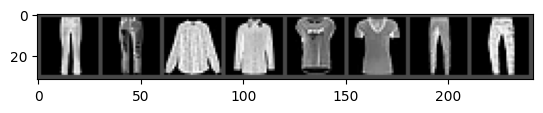

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display the images
def imshow(img):
    img = img*std + mean
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    # Plot some images
    imshow(torchvision.utils.make_grid(images[:8]))  # Display 8 images from the batch
    break

#### Model

In [20]:
model = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)


In [21]:
# Generating a random tensor
input_tensor = torch.rand(5, 28, 28)

# Feeding the tensor into the model
output = model(input_tensor)
print(output.shape)

torch.Size([5, 10])


#### Loss, Optimizer, and Evaluation Function

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [23]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, loss_fn):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [24]:
test_loss, test_accuracy = evaluate(model, testloader, loss_fn)
print(f'test_loss: {test_loss}')
print(f'test_accuracy: {test_accuracy}')

test_loss: 2.3639073610305785
test_accuracy: 3.63


#### Train

In [25]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 20

In [26]:
# train
for epoch in range(max_epoch):
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item()

        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()        

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    test_loss, test_accuracy = evaluate(model, testloader, loss_fn)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/20], Loss: 1.6389, Accuracy: 55.74%, Test Loss: 1.1988, Test Accuracy: 67.74%
Epoch [2/20], Loss: 1.0233, Accuracy: 70.95%, Test Loss: 0.9122, Test Accuracy: 72.27%
Epoch [3/20], Loss: 0.8369, Accuracy: 73.84%, Test Loss: 0.7944, Test Accuracy: 74.26%
Epoch [4/20], Loss: 0.7461, Accuracy: 75.74%, Test Loss: 0.7280, Test Accuracy: 75.98%
Epoch [5/20], Loss: 0.6911, Accuracy: 76.96%, Test Loss: 0.6847, Test Accuracy: 76.84%
Epoch [6/20], Loss: 0.6526, Accuracy: 77.97%, Test Loss: 0.6540, Test Accuracy: 77.43%
Epoch [7/20], Loss: 0.6241, Accuracy: 78.77%, Test Loss: 0.6301, Test Accuracy: 78.20%
Epoch [8/20], Loss: 0.6020, Accuracy: 79.49%, Test Loss: 0.6106, Test Accuracy: 78.87%
Epoch [9/20], Loss: 0.5832, Accuracy: 80.06%, Test Loss: 0.5948, Test Accuracy: 79.46%
Epoch [10/20], Loss: 0.5679, Accuracy: 80.46%, Test Loss: 0.5813, Test Accuracy: 79.59%
Epoch [11/20], Loss: 0.5547, Accuracy: 80.93%, Test Loss: 0.5696, Test Accuracy: 79.96%
Epoch [12/20], Loss: 0.5433, Accuracy: 81

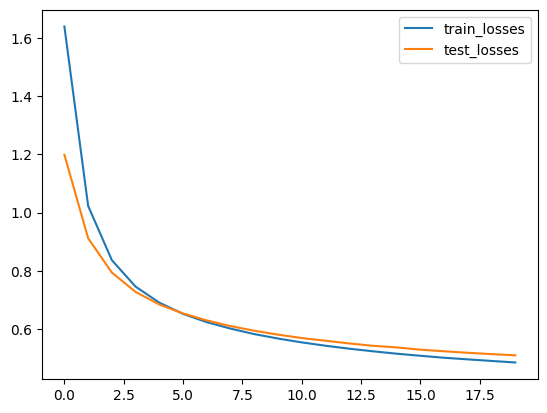

In [27]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

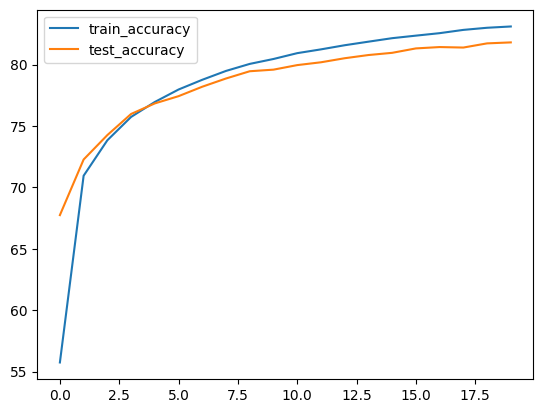

In [28]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()